In [1]:
import numpy as np
import math
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import cartopy
import cartopy.crs as ccrs
import metpy.calc as mpcalc
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import pop_tools 
import matplotlib.path as mpath
import dask
import utils
import pandas as pd

import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

In [2]:
case = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/'+case+'/ocn/proc/tseries/month_1'
variables = ['diatChl', 'coccoChl','spChl','diazChl','mesozooC']
coords = {'x':'TLONG','y':'TLAT'}
keep_vars = variables + list(coords.values())+['dz','KMT','time_bound']
path

'/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch/ocn/proc/tseries/month_1'

### get monthly data and immediately convert it to annual

In [3]:
def preprocess(ds):
    #ds=ds.isel(z_t=0)
    ds=ds.isel(z_t_150m=0)
    return ds

In [4]:
def preprocess2(ds):
    #ds=ds.isel(z_t=0)
    ds=ds.mean(dim='z_t_150m')
    return ds

In [5]:
%%time

ds = xr.Dataset()


for v in variables:  
    print(v)
    files = sorted(glob(f'{path}/{case}.pop.h.{v}.195801-202112.nc'))

    if v=='mesozooC':
        print('got mesozoo, making avg')
        dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True,preprocess=preprocess2)
    else:
        print('got a chl var, getting surf')
        dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True,preprocess=preprocess)

    ds = xr.merge((ds, dsv))

ds = ds.drop([v for v in ds.variables if v not in keep_vars]).squeeze()

diatChl
got a chl var, getting surf
coccoChl
got a chl var, getting surf
spChl
got a chl var, getting surf
diazChl
got a chl var, getting surf
mesozooC
got mesozoo, making avg
CPU times: user 2.15 s, sys: 162 ms, total: 2.31 s
Wall time: 4.99 s


In [6]:
ds["time"] = ds.time_bound.compute().mean(dim="d2")

### spin up some dask to make the processing faster

In [7]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='25GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=25GB',
        project='NCGD0011',
        walltime='01:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [8]:
cluster, client = get_ClusterClient()
cluster.scale(8) 

In [9]:
client

Client Scheduler: tcp://128.117.208.83:38959 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [10]:
ds_grid = pop_tools.get_grid('POP_gx1v7')

area = ds_grid.TAREA
lats = ds_grid.TLAT
lons = ds_grid.TLONG

### Make a mean over the satellite era, add the 4 PFT chl together, and then the chlorophyll data is ready

### Make annual means

In [11]:
ds_ann = ds.resample({'time':'A'}).mean(dim='time').compute()

### Trim it to the same years as the hi res comparison: 1997 to 2021

In [12]:
ds_ann.time[39:64]

<xarray.DataArray 'time' (time: 25)>
array([cftime.DatetimeNoLeap(1997, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1998, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1999, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2000, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2001, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2003, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2004, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2005, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2006, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2007, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2008, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2009, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2010, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2011, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2012, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2013, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2014, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2015, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2016, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2017, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2019, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2020, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2021, 12, 31, 0, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1997-12-31 00:00:00 ... 2021-12-31 00:00:00

In [13]:
ds_ann = ds_ann.isel(time=slice(39,64))

In [14]:
ds = ds_ann.mean(dim='time')

In [15]:
ds

<xarray.Dataset>
Dimensions:   (nlat: 384, nlon: 320, z_t: 60)
Coordinates:
    TLAT      (nlat, nlon) float64 -79.22 -79.22 -79.22 -79.22 ... nan nan nan
    TLONG     (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... nan nan nan nan
Dimensions without coordinates: nlat, nlon, z_t
Data variables:
    KMT       (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    diatChl   (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan nan
    dz        (z_t) float32 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
    coccoChl  (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan nan
    spChl     (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan nan
    diazChl   (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan nan
    mesozooC  (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan nan

In [16]:
cesm_chl = ds.diatChl + ds.spChl + ds.coccoChl + ds.diazChl

### Get the satellite data for chlorophyll

In [17]:
path = '/glade/work/kristenk/satellite_data/globcolour_chl/L3m_'
files = []
files.extend(sorted(glob(f'{path}*.nc')))
ds_sat=xr.open_mfdataset(files,concat_dim='time',combine='nested')
ds_sat = ds_sat.mean(dim='time')

### Get the COPEPOD database

In [18]:
file = '/glade/u/home/kristenk/work/copepod-biomass/data/POP_gx1v7/copepod-2012__cmass-m00-qtr.zarr'
ds_copepod = xr.open_zarr(file, consolidated=False)
ds_copepod['copepod_C']=ds_copepod.copepod_C/12.011

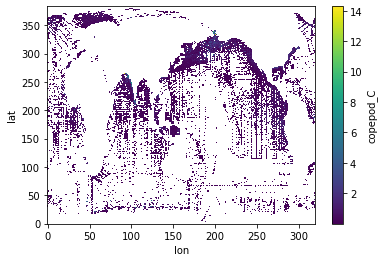

In [19]:
ds_copepod['copepod_C'].plot()

### Make the chlorophyll and copepod maps!

In [20]:
ds_grid_x1 = pop_tools.get_grid('POP_gx1v7')
lons_x1=ds_grid_x1.TLONG
lats_x1=ds_grid_x1.TLAT

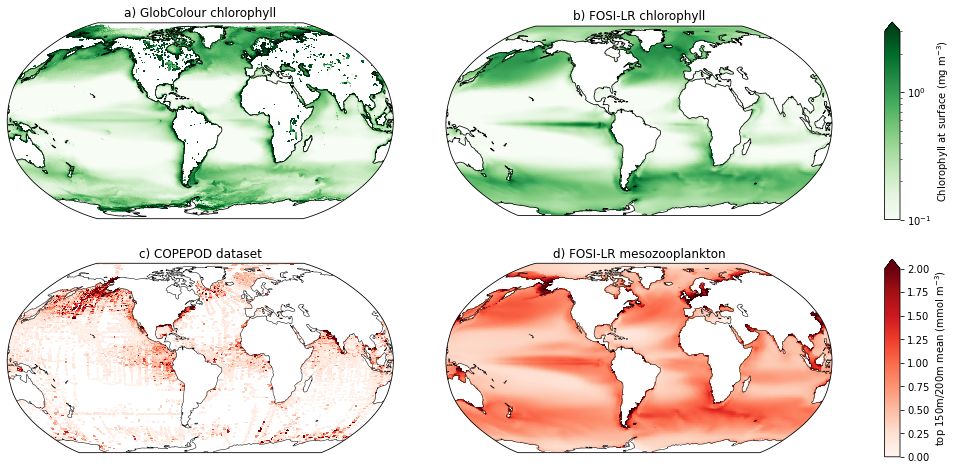

In [21]:
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=(1, 1, 0.04))

prj = ccrs.Robinson(central_longitude=305.0)

ax_chl_sat = plt.subplot(gs[0, 0], projection=prj)
ax_chl_cesm = plt.subplot(gs[0, 1], projection=prj)
ax_meso_cope = plt.subplot(gs[1, 0], projection=prj)
ax_meso_cesm = plt.subplot(gs[1, 1], projection=prj)

ax_chl_sat.set_title('a) GlobColour chlorophyll', fontsize=12)
pc_chl_sat=ax_chl_sat.pcolormesh(ds_sat.lon, ds_sat.lat, ds_sat.CHL1_mean, 
                     cmap='Greens',norm=colors.LogNorm(vmin=0.1, vmax=3),
                     transform=ccrs.PlateCarree())
ax_chl_sat.coastlines('110m',linewidth=0.75)

ax_chl_cesm.set_title('b) FOSI-LR chlorophyll', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_chl)
ax_chl_cesm.coastlines('110m',linewidth=0.75)
pc_chl_cesm=ax_chl_cesm.pcolormesh(lon, lat, field, cmap='Greens',
                 norm=colors.LogNorm(vmin=0.1, vmax=3),transform=ccrs.PlateCarree())




ax_meso_cope.set_title('c) COPEPOD dataset', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_copepod.copepod_C)
pc_meso_cope=ax_meso_cope.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())
ax_meso_cope.coastlines('110m',linewidth=0.5)

ax_meso_cesm.set_title('d) FOSI-LR mesozooplankton', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds.mesozooC)
pc_meso_cesm=ax_meso_cesm.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())
ax_meso_cesm.coastlines('110m',linewidth=0.5)

cax_chl = plt.subplot(gs[0, 2])
cax_meso = plt.subplot(gs[1, 2])

cb_chl = plt.colorbar(pc_chl_cesm, cax=cax_chl,extend='max', 
                      label='Chlorophyll at surface (mg m$^{-3}$)')
cb_meso = plt.colorbar(pc_meso_cesm, cax=cax_meso,extend='max', label='top 150m/200m mean (mmol m$^{-3}$)')




fig.savefig('/glade/work/kristenk/figs/chl_copepod_comparison_x1.png', bbox_inches='tight', dpi=300, format='png');

In [22]:
cluster.close()